✅ ED shape: (42631, 9)
✅ ON-Marg shape: (34, 7)
✅ GeoJSON shape: (34, 8)
✅ All PHUs matched to HUIDs

🔍 Missing values per column (ED):
 public_health_unit                         0
indicator                                  0
time_interval                              0
time_period                                0
start_date_of_time_period                  0
end_date_of_time_period                    0
number_of_cases                            0
population                                 0
cases_per_100_000_population_annualized    0
PHU_CLEAN                                  0
HUID                                       0
dtype: int64

📎 Duplicate rows (ED): 0
✅ Merged shape (ED + ON-Marg): (34, 8)
✅ PHUs with ED rates: 33
✅ PHUs with deprivation values: 33


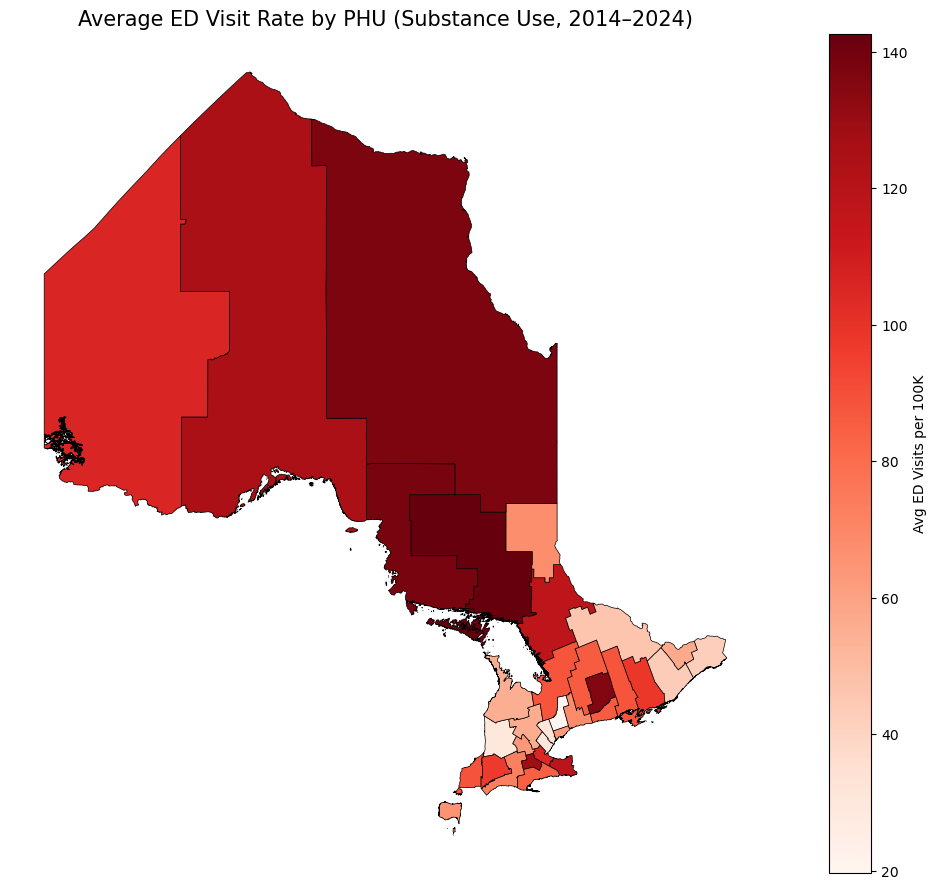

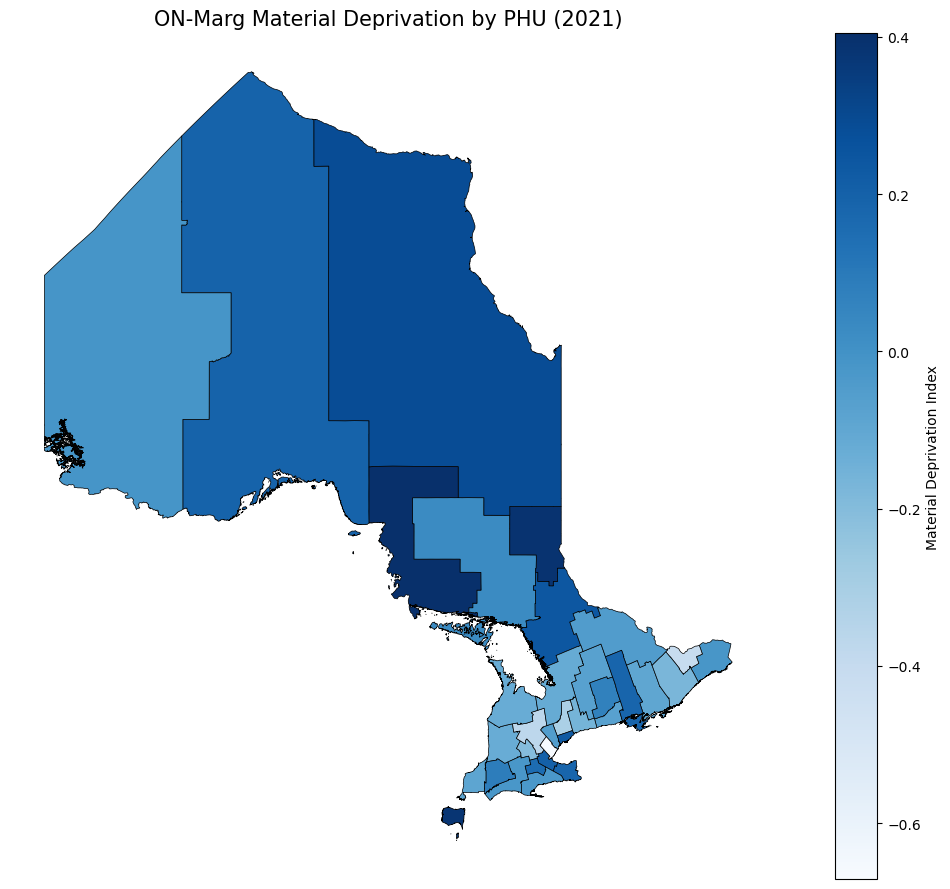

In [17]:
import pandas as pd
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# 1. Load data
ed_path = ("C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//pho_ed_visits_phu_month_2014-2024.csv.csv")
onmarg_path= ("C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//onmarg_phu_static_2021.csv.csv")
geojson_path= ("C://Users//shoaib//Downloads//MOH_PHU_BOUNDARY_-8976796226401221177.geojson")
ed_df = pd.read_csv(ed_path)
onmarg_df = pd.read_csv(onmarg_path)
phu_gdf = gpd.read_file(geojson_path)

# --------------------------
# ERROR CHECK: Basic shapes
# --------------------------
print("✅ ED shape:", ed_df.shape)
print("✅ ON-Marg shape:", onmarg_df.shape)
print("✅ GeoJSON shape:", phu_gdf.shape)

# --------------------------
# Clean PHU names
# --------------------------
ed_df["PHU_CLEAN"] = ed_df["public_health_unit"].str.strip().str.lower()
# Filter for relevant ED visits only (opioid-related poisonings)
# Filter for relevant ED visits only (opioid-related poisonings)
ed_df = ed_df[ ed_df['indicator']
                 .str.contains("ED visits due to opioid-related poisoning", case=False, na=False) ]
ed_df = ed_df[ ed_df['public_health_unit'].str.lower() != "ontario" ]




# --------------------------
# Lookup Dictionary
# --------------------------
phu_lookup = {
    "algoma public health": 2226, "brant county health unit": 2227,
    "chatham-kent public health": 2234, "city of hamilton public health services": 2237,
    "durham region health department": 2230, "eastern ontario health unit": 2258,
    "grey bruce health unit": 2233, "haliburton, kawartha, pine ridge district health unit": 2235,
    "halton region public health": 2236, "hastings prince edward public health": 2238,
    "huron perth public health": 5183, "kfl&a public health": 2241,
    "lambton public health": 2242, "leeds, grenville and lanark district health unit": 2243,
    "middlesex-london health unit": 2244, "niagara region public health": 2246,
    "north bay parry sound district health unit": 2247, "northwestern health unit": 2249,
    "ottawa public health": 2251, "peel public health": 2253,
    "peterborough public health": 2255, "porcupine health unit": 2256,
    "public health sudbury & districts": 2261, "region of waterloo public health and emergency services": 2265,
    "renfrew county and district health unit": 2257, "simcoe muskoka district health unit": 2260,
    "southwestern public health": 4913, "thunder bay district health unit": 2262,
    "timiskaming health unit": 2263, "toronto public health": 3895,
    "wellington-dufferin-guelph public health": 2266, "windsor-essex county health unit": 2268,
    "york region public health": 2270, "haldimand-norfolk health unit": 2239,
    "kingston, frontenac and lennox & addington public health": 2241,  # same as "kfl&a"
    "leeds, grenville & lanark district health unit": 2243
    
}

# --------------------------
# Map HUIDs
# --------------------------
ed_df["HUID"] = ed_df["PHU_CLEAN"].map(phu_lookup)

# Check missing HUIDs
missing_huids = ed_df[ed_df["HUID"].isna()]["PHU_CLEAN"].unique()
if len(missing_huids) > 0:
    print("⚠️ Unmatched PHUs:", missing_huids)
else:
    print("✅ All PHUs matched to HUIDs")

# --------------------------
# Null/duplicate checks
# --------------------------
print("\n🔍 Missing values per column (ED):\n", ed_df.isnull().sum())
print("\n📎 Duplicate rows (ED):", ed_df.duplicated().sum())

# --------------------------
# Validate required columns
# --------------------------
required_cols = ['HUID', 'cases_per_100_000_population_annualized']
for col in required_cols:
    if col not in ed_df.columns:
        raise ValueError(f"❌ Missing column in ED data: {col}")

# --------------------------
# Aggregate average ED rate
# --------------------------
avg_ed = (
    ed_df.groupby("HUID")["cases_per_100_000_population_annualized"]
    .mean()
    .reset_index()
    .rename(columns={"cases_per_100_000_population_annualized": "avg_ed_rate"})
)

# --------------------------
# Merge with ON-Marg
# --------------------------
merged_df = avg_ed.merge(onmarg_df, on="HUID", how="left")
print("✅ Merged shape (ED + ON-Marg):", merged_df.shape)

# --------------------------
# Merge with GeoJSON
# --------------------------
map_df = phu_gdf.merge(merged_df, left_on="PHU_ID", right_on="HUID", how="left")

# Final merge checks
print("✅ PHUs with ED rates:", map_df['avg_ed_rate'].notna().sum())
print("✅ PHUs with deprivation values:", map_df['material_resources_HUID'].notna().sum())

# --------------------------
# Choropleth: Avg ED Visit Rate
# --------------------------
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
map_df.plot(column="avg_ed_rate",
            cmap="Reds",
            linewidth=0.5,
            edgecolor="black",
            legend=True,
            legend_kwds={"label": "Avg ED Visits per 100K"},
            ax=ax)
ax.set_title("Average ED Visit Rate by PHU (Substance Use, 2014–2024)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# --------------------------
# Choropleth: Material Deprivation
# --------------------------
fig, ax = plt.subplots(1, 1, figsize=(14, 9))
map_df.plot(column="material_resources_HUID",
            cmap="Blues",
            linewidth=0.5,
            edgecolor="black",
            legend=True,
            legend_kwds={"label": "Material Deprivation Index"},
            ax=ax)
ax.set_title("ON-Marg Material Deprivation by PHU (2021)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# -- 1. Load monthly death data
df = pd.read_csv("your_substance_deaths.csv")
df['date'] = pd.to_datetime(df['start_date_of_time_period'])
df['year'] = df['date'].dt.year

# -- 2. Filter to “death” indicators only
death_mask = df['indicator'].str.contains("death", case=False, na=False)
df = df[death_mask]

# -- 3a. INCORRECT: sum of monthly annualized rates
bad = df.groupby(['year','indicator'])['cases_per_100_000_population_annualized'] \
        .sum() \
        .unstack()

# -- 3b. CORRECT: sum deaths and sum population, then rate once
agg = df.groupby(['year','indicator']).agg(
    total_deaths=('number_of_cases','sum'),
    avg_pop     =('population','mean')
).reset_index()
agg['correct_rate'] = agg['total_deaths'] / agg['avg_pop'] * 100000

# -- 4. Compare peak values
for substance in agg['indicator'].unique():
    sub = agg[agg['indicator']==substance]
    print(f"{substance}: incorrect peak = {bad[substance].max():.1f}, "
          f"correct peak = {sub['correct_rate'].max():.1f}")
